# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt 

(1 балл)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)

(3 балла)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на метрике cart_added_cnt

(2 балла)

4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+)
подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая

(2 балла)

# Импорт библиотек, и данных, и функций

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

In [2]:
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

shop_metrics_new.sample(5)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
159622,1515915625599809309,B,1,1,28.25,0.0,0.0,0,0
47742,1515915625564451163,B,1,4,115.55,0.0,0.0,0,0
195583,1515915625606292558,B,1,1,11.00,0.0,0.0,0,0
108860,1515915625592684920,B,1,3,1597.68,0.0,0.0,0,0
11202,1515915625546836307,B,1,2,40.96,0.0,0.0,0,0


In [3]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

def groups_splitter(df, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()


In [4]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()

    return df

In [5]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

# 1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt 

In [6]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')

In [7]:
print(ranked[ranked.group == 'A']['rank'].mean(),
      ranked[ranked.group == 'B']['rank'].mean(),
      ((ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) /
       ranked[ranked.group == 'A']['rank'].mean()*100))

print(stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank']))

stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
                   shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

111170.45633348604 111351.6421897482 0.16298022175842064
Ttest_indResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916)


MannwhitneyuResult(statistic=6179368188.5, pvalue=0.2025319893087626)

 __Оба тесты показывают практически одинаковый p_value__

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:58<00:00,  1.67it/s]


-0.9999987137420602
 power: 100.0% , correctness: 95.39999999999999%


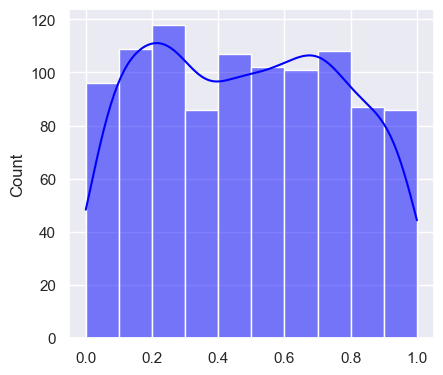

In [8]:
# мощность и корректность для ранговой трансформации

shop = shop_metrics_new.drop(columns=['group'])

correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    ranked_df = rank_transformation(new_df[new_df.group == 'A'], new_df[new_df.group == 'B'], 'cart_added_cnt')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(new_df[new_df.group == 'A'], new_df_b, 'cart_added_cnt')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']


    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)

print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:16<00:00,  1.62it/s]

 power: 100.0% , correctness: 94.6%


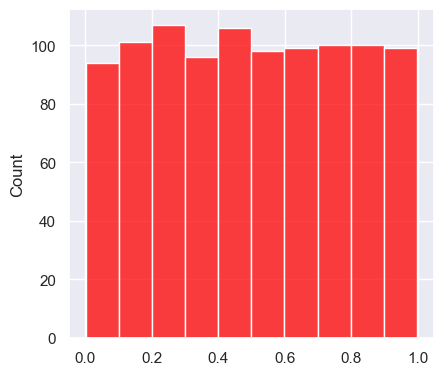

In [9]:
correctness = []
power = []

for i in tqdm(range(1000)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['cart_added_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['cart_added_cnt']
    
    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05

    p_correctness, p_power = stats.mannwhitneyu(vec_a, vec_b)[1], stats.mannwhitneyu(vec_a, vec_b_effect)[1]
    correctness.append(p_correctness)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='red')

power = np.array(power)
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

# 2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)

## Обычная метрика

In [10]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

print('\033[1m'+'t-test'+'\033[0m')
print(stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped']))

t-test
Ttest_indResult(statistic=-1.3855896128552472, pvalue=0.16587364048446882)


In [11]:
print('\033[1m'+'Средние'+'\033[0m')

print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')

print('\033[1m'+'Дисперсии'+'\033[0m')


print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}')

Средние
метрика_cuped A: 0.13638231572690157,         метрика_cuped B: 0.13721028984747924
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813
Дисперсии
метрика_cuped A: 0.018235183599737075,         метрика_cuped B: 0.02149536345518971
метрика без cuped A: 0.3805867322092098,         метрика без cuped B: 0.4247189893563619


__Из значимых изменений -- сильно сокращаются дисперсии при тех же средних__

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:45<00:00,  1.55it/s]


 power: 100.0% , correctness: 95.5%


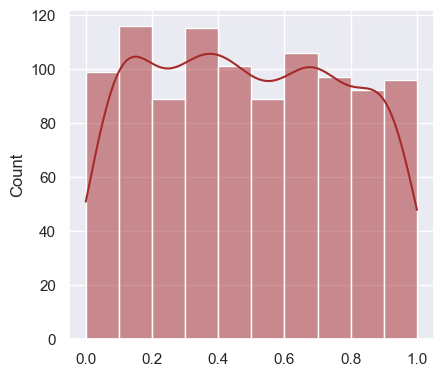

In [12]:
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.05


    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

## Логарифмированная метрика

In [13]:
shop_metrics_all['ln_cart_added_cnt'] = np.log(shop_metrics_all['cart_added_cnt']+1)
shop_metrics_all['ln_cart_added_cnt_covariate'] = np.log1p(shop_metrics_all['cart_added_cnt_covariate']+1)
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['ln_cart_added_cnt'])

print('\033[1m'+'t-test'+'\033[0m')

print(stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['ln_cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['ln_cart_added_cnt_cuped']))

t-test
Ttest_indResult(statistic=-1.7814011922262785, pvalue=0.0748482971637577)


In [14]:
print('\033[1m'+'Средние'+'\033[0m')

print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["ln_cart_added_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["ln_cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["ln_cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["ln_cart_added_cnt"].mean()}')

print('\033[1m'+'Дисперсии'+'\033[0m')


print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["ln_cart_added_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["ln_cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["ln_cart_added_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["ln_cart_added_cnt"].var()}')

Средние
метрика_cuped A: 0.0803370848010829,         метрика_cuped B: 0.08072536244233741
метрика без cuped A: 0.0797428906264097,         метрика без cuped B: 0.08132020317246845
Дисперсии
метрика_cuped A: 0.002786515421119718,         метрика_cuped B: 0.0024990240700704614
метрика без cuped A: 0.0646623295575808,         метрика без cuped B: 0.06628259108485138


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:18<00:00,  1.47it/s]

 power: 100.0% , correctness: 95.6%


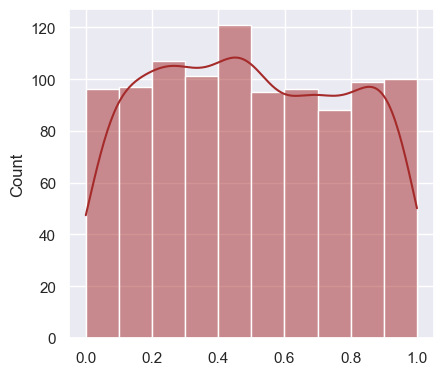

In [15]:
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    all_df['ln_cart_added_cnt'] = np.log1p(all_df['cart_added_cnt'])
    all_df['ln_cart_added_cnt_covariate'] = np.log1p(all_df['cart_added_cnt_covariate'])

    cuped_df = cuped_transform(all_df, ['ln_cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['ln_cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['ln_cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.05


    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

## Метрика cart_added_cnt (а после подвергнуть ранговому преобразованию)

In [9]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

ranked = rank_transformation(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'],
                             shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'], 'cart_added_cnt_cuped')

print('\033[1m'+'t-test'+'\033[0m')

stats.ttest_ind(ranked[ranked.group == 'A']['rank'],
                ranked[ranked.group == 'B']['rank'])

t-test


Ttest_indResult(statistic=-1.4459909525623789, pvalue=0.14818114788143422)

In [11]:
print('\033[1m'+'Средние'+'\033[0m')

print(f'метрика_cuped A: {ranked[ranked.group == "A"]["rank"].mean()}, \
        метрика_cuped B: {ranked[ranked.group == "B"]["rank"].mean()}')
print(f'метрика без cuped A: {ranked[ranked.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {ranked[ranked.group == "B"]["cart_added_cnt"].mean()}')

print('\033[1m'+'Дисперсии'+'\033[0m')


print(f'метрика_cuped A: {ranked[ranked.group == "A"]["rank"].var()}, \
        метрика_cuped B: {ranked[ranked.group == "B"]["rank"].var()}')
print(f'метрика без cuped A: {ranked[ranked.group == "A"]["cart_added_cnt"].var()}, \
        метрика без cuped B: {ranked[ranked.group == "B"]["cart_added_cnt"].var()}')

Средние
метрика_cuped A: 111157.3299691882,         метрика_cuped B: 111364.78283723022
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813
Дисперсии
метрика_cuped A: 1138307738.1923919,         метрика_cuped B: 1151768826.5573704
метрика без cuped A: 0.3805867322092098,         метрика без cuped B: 0.4247189893563619


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:07<00:00,  1.27it/s]

 power: 100.0% , correctness: 95.19999999999999%


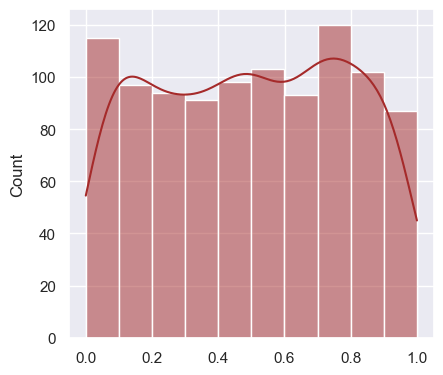

In [18]:
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    ranked_df = rank_transformation(cuped_df[cuped_df.group == 'A'],
                             cuped_df[cuped_df.group == 'B'], 'cart_added_cnt_cuped')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']

    vec_b_effect = cuped_df[cuped_df['group'] == 'B']['cart_added_cnt_cuped'] * 1.05
    new_df_b = cuped_df[cuped_df.group == 'B'].drop(columns=['cart_added_cnt_cuped'])
    new_df_b['cart_added_cnt_cuped'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(cuped_df[cuped_df.group == 'A'], new_df_b, 'cart_added_cnt_cuped')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']


    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)


correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

## Вывод
CUPED помогает нам (а именно уменьшает дисперсию) при обычной и логарифмированной метрике\
В случае ранговой трансформации судить сложно, разве что у нас довольно близкими становятся дисперсии в разных группах\
По p-value лучше всего показало себя логарифмирование метрики (практически приблизилось к 5%)